# **POS Tagging using RNN**
*RIT - ENGL.581 Term Project - Fall 2021*

---

## **README**

---

> **Authors:** Max Kipust, Khamin Nathabheem, Tyler Arnett

> **Description:** A notebook for use in a Google Colab environment. This serves the purpose of training and evaluating an RNN model with POS tagging. The data provided to the model has been collected from interpretive languages . This is to research how a model of this type can be used to assess certain patterns in coding and its associated comments. The potential of this type of tagging is to allow for standardization and assessments of code.

> **Usage:** ***Easiest way to the script by default is to open "Runtime" in the topbar in Google Colab and then select "Run all".***User may run each section individually and once. Upon reaching section 7, Represent Inputs using Spacy, please be sure to run the line that will download `en_core_web_lg`. Without this, there may be errors, if you have already done this, proceed to run each section and assess the results. This .ipynb notebook is intended to be used in a Google Colab environment. For best results, please use a Google Colab Environment. Google Colab was used because the attempts in the ondemand environment were met with many complications. Resolving these issues were out of the scope of time available which caused us to fall back to this environment instead.

### **Table of Contents**

---

1.   **Imports**

> Bring in packages such as keras, nltk, spacy, pandas, and matplotlib. These will give us the ability to import our data, format and preprocess the data, train our model, and evaluate our model. Additionally, we will be able to visually represent some of this data along the way.

2.   **Importing data from Github**

> The data is coming from a csv in GitHub.This data includes: `TYPE, IDENTIFIER 	GRAMMAR_PATTERN, WORD, SWUM_TAG, POSSE_TAG, STANFORD_TAG, FLAIR_TAG, POSITION, MAXPOSITION, NORMALIZED_POSITION, CONTEXT, CORRECT_TAG, SYSTEM, IDENTIFIER_CODE, ID`. Additionally, an EOI is added to the `IDENTIFIER` column.

3.   **Mapping to X and Y**

> Taking our data, we process what we need into X and Y arrays. This will be important for later training of the model. The X array recieves the `IDENTIFIER` column split. Respectively, Y recieves the `GRAMMAR_PATTERN` column split.

4.   **Calculating Metics**

> Using the arrays, Vocabulary size, number of tags, and number of tagged identifiers can be displayed. This section is to ensure that the data has been processed correctly. This data shows up later as it is needed to train the model.

5.   **Tokenizer/Encode**

> Using the Tokenizer from Keras text processing, we convert our X and Y arrays into a numeric representation of the data. This allows for it to be interpretted by the code during our model training.

6.   **Padding**

> This section does additional preparation for the model creation. It pads the, now encoded, X and Y arrays using `pad_sequences()` from Keras preprocessing. Additionally, several lengths needed by this padding process and used later in the model training.

7.   **Represent Inputs using Spacy**

> Assign word vectors using Spacy. (If this is the first run, you may need to run the line `!python -m spacy download en_core_web_lg`. This entire step may take a while to run. Additionally, from Keras untils, we use `to_categorical()` on the Y array and we print out some of our values from earlier in the notebook as a point of reference. This should only be ran once. If this is ran multiple times by accident, it can result in a malformed array which breaks step 8. If this happens and you want to fix it, start from the top and it will rebuild these arrays again correctly.

8.   **Training the Model**

> Using a culmination of the above steps, a model is able to be trained given the `IDENTIFIER`, `GRAMMAR_PATTERN`, fields that are now represented using a word vectors and details such as the sequence length, vocabulary size and other points of data fufilled in the previous steps. Additionally, this can later be assessed thanks to `validation_data=(X_validation, Y_validation)` being provided to the model as well.

9.   **Accuracy Assessment**

> Assessing the accuracy of the model is done visually using a `matplotlib` plot. Loss and accuracy are also calculated and printed below this plot using `evaluate()` from Keras model. Additionally, the `X_unseen` and `Y_unseen` arrays are decoded and used in order to provided a `confusion_matrix` and `classification_report`. These are both provided in `sklearn.metrics`. Both are then printed for researcher interpretation.


---

### **Future Development**

In the future, this could be used as the proof of concept for a model that can encourage good coding practices and standardization of them. Additionally, larger data sets provided to the model could result in an even more accurate and well trained model. This model currently is suited to work in a Google Colab environment. Future work could include attempting to bring this into the ondemand or other environments. Furthermore, testing different model types and data types could potentially yield even more diverse results.

---


# 1. Imports
Keras, nltk, numpy, and various plotting tooks and model packages are imported to facilitate the RNN pos tagging project.

In [ ]:
#disable the extraneous warnings we may encounter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#---imports---

#useful and helpful stuff
import numpy as np
import seaborn as sns
import nltk
import spacy
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from gensim.models import KeyedVectors, Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN, TimeDistributed, Dense, Embedding
from keras.preprocessing.text import Tokenizer


In [ ]:
tags = [
    'n',
    'dt',
    'cj',
    'p',
    'npl',
    'nm',
    'v',
    'vm',
    'pr',
    'd',
    'pre'
]

# 2. Importing the data from GitHub
https://raw.githubusercontent.com/Maxakipust/id_pos/main/data/orig_training_data.csv contains pos tags and identifiers. Parsing this CSV gives part of what we need for an RNN. Additionally, https://raw.githubusercontent.com/Maxakipust/id_pos/main/data/orig_unseen_testing_data.csv contains an unseen version for later use.

In [ ]:
#load the orig_training_data.csv into the notebook for training the model.
print("Training Data:\n")
url = 'https://raw.githubusercontent.com/Maxakipust/id_pos/main/data/orig_training_data.csv'
df = pd.read_csv(url)             # load the csv from the Github repository
df.head()                         # changed from df to df.head to save space.

Training Data:



,TYPE,IDENTIFIER,GRAMMAR_PATTERN,WORD,SWUM_TAG,POSSE_TAG,STANFORD_TAG,FLAIR_TAG,POSITION,MAXPOSITION,NORMALIZED_POSITION,CONTEXT,CORRECT_TAG,SYSTEM,IDENTIFIER_CODE,ID
0,Map,action To Index Map,N P NM N,action,NM,V,N,N,0,4,0,1,N,{'gimp.srcml.xml_identifiers'},0,1
1,Map,action To Index Map,N P NM N,To,NM,P,P,P,1,4,1,1,P,{'gimp.srcml.xml_identifiers'},0,2
2,Map,action To Index Map,N P NM N,Index,NM,N,N,N,2,4,1,1,NM,{'gimp.srcml.xml_identifiers'},0,3
3,Map,action To Index Map,N P NM N,Map,N,N,N,N,3,4,2,1,N,{'gimp.srcml.xml_identifiers'},0,4
4,KToggleAction,action View Show Master Pages,NM N V NM NPL,action,NM,N,N,N,0,5,0,1,NM,{'elasticsearch.srcml.xml_identifiers'},1,5


In [ ]:
#"unseen testing data" is used later, testing the model trained using "training data".
print("Unseen Testing Data:\n")
url_unseen = 'https://raw.githubusercontent.com/Maxakipust/id_pos/main/data/orig_unseen_testing_data.csv'
df_unseen = pd.read_csv(url_unseen)
df_unseen.head()

Unseen Testing Data:



,IDENTIFIER,GRAMMAR_PATTERN,WORD,SWUM_TAG,POSSE_TAG,STANFORD_TAG,FLAIR_TAG,POSITION,MAXPOSITION,NORMALIZED_POSITION,CONTEXT,CORRECT_TAG,SYSTEM,IDENTIFIER_CODE,ID
0,accelerometer Data,NM N,accelerometer,NM,N,N,N,0,2,0,5,NM,openFrameworks,0,1
1,accelerometer Data,NM N,Data,N,N,N,NPL,1,2,2,5,N,openFrameworks,0,2
2,actual,N,actual,N,N,N,NM,0,1,0,5,N,junit4,1,3
3,actual Count,NM N,actual,NM,NM,NM,NM,0,2,0,1,NM,okhttp,2,4
4,actual Count,NM N,Count,N,N,N,N,1,2,2,1,N,okhttp,2,5


In [ ]:
# this is not currently needed but could make an appearance someday.
# add the EOI to the IDENTIFIER field
#df['IDENTIFIER'] += ' EOI'
#df['GRAMMAR_PATTERN'] += ' EOI'
#df.head()         #changed from df to df.head()

# 3. Mapping to X and Y
Below is a loop that fills X and Y with the word from IDENTIFIER and its corresponding POS tag/EOI from GRAMMAR_PATTERN.

In [ ]:
# training data here
X = []    #this is to later become populated with IDENTIFIER field
Y = []    #this is to later become populated with GRAMMAR_PATTERN field
for _, row in df.iterrows():
  X.append(row['IDENTIFIER'].split()) 
  Y.append(row['GRAMMAR_PATTERN'].split())

  #sample to make sure X and Y are correct
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['action', 'To', 'Index', 'Map'] 

sample Y:  ['N', 'P', 'NM', 'N'] 



In [ ]:
# unseen testing data here
X_unseen = []    #this is to later become populated with IDENTIFIER field
Y_unseen = []    #this is to later become populated with GRAMMAR_PATTERN field

for _, row in df_unseen.iterrows():
  X_unseen.append(row['IDENTIFIER'].split()) 
  Y_unseen.append(row['GRAMMAR_PATTERN'].split())

  #sample to make sure X and Y are correct
print('sample X_unseen: ', X_unseen[0], '\n')
print('sample Y_unseen: ', Y_unseen[0], '\n')

sample X_unseen:  ['accelerometer', 'Data'] 

sample Y_unseen:  ['NM', 'N'] 



# 4. Calculate Metrics
Such as the Vocabulary size, number of tags, and number of tagged identifiers.

In [ ]:

  # these tags are later used in the model generation
num_identifiers = len(set([word.lower() for sentence in X for word in sentence]))
num_tags = len(set([word.lower() for sentence in Y for word in sentence]))
  # print them just to make sure they are correct
print("Total number of tagged identifers: {}".format(len(X)))
print("Vocabulary size: {}".format(num_identifiers))
print("Total number of tags: {}".format(num_tags))



Total number of tagged identifers: 3550
Vocabulary size: 1582
Total number of tags: 10


In [ ]:

  # these tags are later used in the model generation
num_unseen_identifiers = len(set([word.lower() for sentence in X_unseen for word in sentence]))
num_unseen_tags = len(set([word.lower() for sentence in Y_unseen for word in sentence]))
  # print them just to make sure they are correct
print("Total number of tagged identifers: {}".format(len(X_unseen)))
print("Vocabulary size: {}".format(num_unseen_identifiers))
print("Total number of tags: {}".format(num_unseen_tags))


Total number of tagged identifers: 977
Vocabulary size: 626
Total number of tags: 10


# 5. Tokenizer/Encode
Take the X and Y and use the Tokenizer from keras text processing to encode them. The printed result is a numeric representation of the previous sample X and Y.

In [ ]:
  # using the Tokenizer from keras preprocessing, encode X and Y of the training data

  # X encoding using keras tokenizer
id_tokenizer = Tokenizer()
id_tokenizer.fit_on_texts(X)
X_encoded = id_tokenizer.texts_to_sequences(X)
  # Y encoding using keras tokenizer
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

  # print to make sure the encoding was successful
print("X encoded: " + str(X_encoded[0]))
print("Y encoded: " + str(Y_encoded[0]))
print("X example: " + str(id_tokenizer.sequences_to_texts([X_encoded[0]])))
print("Y example: " + str(tag_tokenizer.sequences_to_texts([Y_encoded[0]])))

X encoded: [36, 3, 8, 33]
Y encoded: [2, 6, 1, 2]
X example: ['action to index map']
Y example: ['n p nm n']


In [ ]:
#...tokenize unseen data X and Y as well.
  # X encoding using keras tokenizer
id_tokenizer_unseen = Tokenizer()
id_tokenizer_unseen.fit_on_texts(X_unseen)
X_unseen_encoded = id_tokenizer_unseen.texts_to_sequences(X_unseen)
  # Y encoding using keras tokenizer
tag_tokenizer_unseen = Tokenizer()
tag_tokenizer_unseen.fit_on_texts(Y_unseen)
Y_unseen_encoded = tag_tokenizer_unseen.texts_to_sequences(Y_unseen)

  # print to make sure the encoding was successful
print("X encoded: " + str(X_unseen_encoded[0]))
print("Y encoded: " + str(Y_unseen_encoded[0]))
print("X example: " + str(id_tokenizer_unseen.sequences_to_texts([X_unseen_encoded[0]])))
print("Y example: " + str(tag_tokenizer_unseen.sequences_to_texts([Y_unseen_encoded[0]])))

X encoded: [437, 8]
Y encoded: [1, 2]
X example: ['accelerometer data']
Y example: ['nm n']


# 6. Padding
Pad sequences for X and Y.

In [ ]:
#training data check for "disparate input-output lengths" and print it out.
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("Training: "+str(sum(different_length))+" sentences have disparate input-output lengths.")

Training: 0 sentences have disparate input-output lengths.


In [ ]:
#unseen data check for "disparate input-output lengths" and print it out.
different_length_unseen = [1 if len(input) != len(output) else 0 for input, output in zip(X_unseen_encoded, Y_unseen_encoded)]
print("Unseen Testing: "+str(sum(different_length_unseen))+" sentences have disparate input-output lengths.")

Unseen Testing: 0 sentences have disparate input-output lengths.


In [ ]:
# check length of longest sequence
lengths = [len(seq) for seq in X_encoded]
MAX_SEQ_LENGTH = max(lengths) + 1
print("Length of longest sequence: "+str(MAX_SEQ_LENGTH))

Length of longest sequence: 11


Lengths boxplot(training):



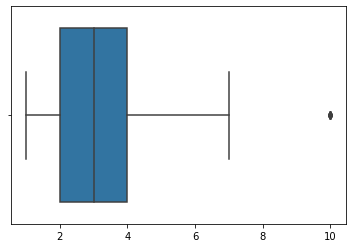

In [ ]:
#plot the lengths to have a visual representation
print("Lengths boxplot(training):\n")
sns.boxplot(lengths)
plt.show()

In [ ]:
#add padding to X and Y training data
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post") # won't truncate since we just use the max length
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post") # given seq lengths are small due to running on ids, truncating is probably pointless
X, Y = X_padded, Y_padded
#print the shapes
print("X shape: " + str(X.shape))
print("Y shape: " + str(Y.shape))

X shape: (3550, 11)
Y shape: (3550, 11)


In [ ]:
#add padding to X and Y Test data unseen
X_unseen_padded = pad_sequences(X_unseen_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_unseen_padded = pad_sequences(Y_unseen_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
X_unseen, Y_unseen = X_unseen_padded, Y_unseen_padded
Y_unseen = to_categorical(Y_unseen)
#print the shapes
print("X(unseen) shape: " + str(X_unseen.shape))
print("Y(unseen) shape: " + str(Y_unseen.shape))

X(unseen) shape: (977, 11)
Y(unseen) shape: (977, 11, 11)


# 7. Represent Inputs using Spacy
Assign word vectors using Spacy and `en_core_web_lg`. If this is the first run, you may need to uncomment `#!python -m spacy download en_core_web_lg` in order to proceed. Additionally, only run this cell once, sometimes it makes the shapes of the data become malformed.

This step may take a while, esspecially if the environment is new.

In [ ]:
#IF THERE IS AN ERROR, THIS LINE NEEDS TO BE RAN
!python -m spacy download en_core_web_lg
#THIS WILL TAKE A WHILE AND ONLY NEEDS TO BE DONE ONCE PER ENVIRONMENT.

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=5ee4329d894d878c200091aaf475bb54d98bf4b72b476990e9c779db23ee5bce
  Stored in directory: /tmp/pip-ephem-wheel-cache-6co3t8r7/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
# assign word vectors
EMBEDDING_SIZE  = 300   # each word in model is represented using 
                        # a 300 dimensional vector.
VOCABULARY_SIZE = len(id_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
id2index = id_tokenizer.word_index

import en_core_web_lg
nlp = en_core_web_lg.load()

# copy vectors from word2vec model to the words present in corpus
for id, index in id2index.items():
    try:
        embedding_weights[index] = nlp(id).vector
    except KeyError:
        pass

In [ ]:
#print the shape of X, Y, and Y after to_catgorical is ran.
print("X shape: "+ str(X.shape))
print("Y shape before categorical: "+str(Y.shape))
# Y to categorical
Y = to_categorical(Y)
print("X shape"+str(X.shape))
print("Y shape after categorical: "+str(Y.shape))

X shape: (3550, 11)
Y shape before categorical: (3550, 11)
X shape(3550, 11)
Y shape after categorical: (3550, 11, 11)


In [ ]:
# lets print some of the data we have so far for reference:
print("X encoded:"+str(X_encoded))
print("Y encoded:"+str(Y_encoded))
print("Total number of tagged identifers: "+str(len(X)))
print("Vocabulary size: "+str(num_identifiers))
print("Total number of tags: "+str(num_tags))

X encoded:[[36, 3, 8, 33], [36, 3, 8, 33], [36, 3, 8, 33], [36, 3, 8, 33], [36, 47, 361, 527, 528], [36, 47, 361, 527, 528], [36, 47, 361, 527, 528], [36, 47, 361, 527, 528], [36, 47, 361, 527, 528], [116, 1148], [116, 1148], [362, 21], [362, 21], [57, 660, 3, 661], [57, 660, 3, 661], [57, 660, 3, 661], [57, 660, 3, 661], [843, 268, 844], [843, 268, 844], [843, 268, 844], [234, 4, 845], [234, 4, 845], [234, 4, 845], [96, 529], [96, 529], [205, 58, 846], [205, 58, 846], [205, 58, 846], [847], [1533], [80, 530], [80, 530], [269, 28, 235, 444, 206, 21], [269, 28, 235, 444, 206, 21], [269, 28, 235, 444, 206, 21], [269, 28, 235, 444, 206, 21], [269, 28, 235, 444, 206, 21], [269, 28, 235, 444, 206, 21], [97, 5, 848], [97, 5, 848], [97, 5, 848], [97, 1149], [97, 1149], [363, 1150], [363, 1150], [1534], [849, 9, 12], [849, 9, 12], [849, 9, 12], [1151, 69], [1151, 69], [445, 850], [445, 850], [1535], [851, 27, 145], [851, 27, 145], [851, 27, 145], [364], [662], [98, 306], [98, 306], [207, 531],

In [ ]:
# lets print some of the data we have so far for reference:
print("X unseen encoded:"+str(X_unseen_encoded))
print("Y unseen encoded:"+str(Y_unseen_encoded))
print("Total number of tagged identifers(unseen): "+str(len(X_unseen)))
print("Vocabulary size: "+str(num_unseen_identifiers))
print("Total number of tags: "+str(num_unseen_tags))

X unseen encoded:[[437, 8], [437, 8], [146], [146, 46], [146, 46], [146, 438], [146, 438], [284, 285, 286], [284, 285, 286], [284, 285, 286], [183, 25, 58, 19], [183, 25, 58, 19], [183, 25, 58, 19], [183, 25, 58, 19], [439, 21], [439, 21], [440, 441], [440, 441], [287, 288, 289], [287, 288, 289], [287, 288, 289], [442, 147], [442, 147], [148, 9], [148, 9], [290, 75, 107], [290, 75, 107], [290, 75, 107], [596], [597], [443, 76], [443, 76], [59, 291, 292], [59, 291, 292], [59, 291, 292], [59, 444], [59, 444], [59, 293, 294], [59, 293, 294], [59, 293, 294], [184, 77, 185, 186], [184, 77, 185, 186], [184, 77, 185, 186], [184, 77, 185, 186], [445, 187], [445, 187], [188, 149], [188, 149], [188, 47], [188, 47], [189, 446], [189, 446], [447, 60], [447, 60], [448, 30], [448, 30], [295, 8, 16], [295, 8, 16], [295, 8, 16], [449, 48], [449, 48], [598], [49, 296, 297], [49, 296, 297], [49, 296, 297], [49, 190, 61, 191], [49, 190, 61, 191], [49, 190, 61, 191], [49, 190, 61, 191], [49, 450], [49, 45

# 8. Training the Model
Train the model using out X and Y encoded data. Additionally, provide "X_validation" and "Y_validation" in order to later assess the accuracy of the resulting model.

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=4)
#X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.15, random_state=4)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.15, random_state=4)

# define the model
model = Sequential()
model.add(Embedding(input_dim=VOCABULARY_SIZE,
                    output_dim=EMBEDDING_SIZE,
                    input_length=MAX_SEQ_LENGTH,
                    weights=[embedding_weights],
                    trainable=True))
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(num_tags + 1, activation='softmax')))
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
# fit the model
training = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_data=(X_validation, Y_validation))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           474900    
                                                                 
 lstm_1 (LSTM)               (None, 11, 64)            93440     
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 11)           715       
 tributed)                                                       
                                                                 
Total params: 569,055
Trainable params: 569,055
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
24/24 [==============================] - 4s 73ms/step - loss: 2.0511 - categorical_accuracy: 0.7999 - val_loss: 1.5135 - val_categorical_accuracy: 0.7778
Epoch 2/50
24/24 [==============================] - 1s 47ms/step - loss: 1.1

# 9. Accuracy Assessment
Using the model, plot the accuracy vs epoch to visually represent our trained models accuracy.

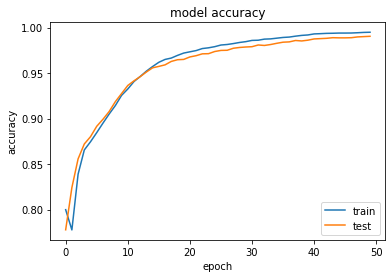

In [ ]:
# visualise training history
plt.plot(training.history['categorical_accuracy'])
plt.plot(training.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

---
BELOW THIS IS TRAINING TEST DATA

In [ ]:
# Confusion matrix & Classification report. This is training test data.
# using sklearn's confusion_matrix and classification_report
#
# Accuracy
#print("Accuracy and Loss of training test data:\n")
#loss, accuracy = model.evaluate(X, Y, verbose = 0)
#print("\nLoss & Accuracy:\n")
#print("Loss: {0},\nAccuracy: {1}\n".format(loss, accuracy))


def print_confusion(confusion):
  pd.options.display.max_rows = len(tags)+5
  pd.options.display.max_columns = len(tags)+5
  print(pd.DataFrame(confusion,index=list(map((lambda x: 'true:'+x), tags)), columns=list(map((lambda x: 'pred:'+x), tags))))

#print(id_tokenizer.sequences_to_texts([X_test[0]]))
#print(tag_tokenizer.sequences_to_texts(np.argmax(Y_test, axis=2)))
#actual = [a.split() for a in tag_tokenizer.sequences_to_texts(np.argmax(Y_test, axis=2))]
#pred = [a.split() for a in tag_tokenizer.sequences_to_texts(np.argmax(model.predict(X_test), axis=2))]
#a = []
#p = []
#for i in actual:
#  for j in i:
#    a.append(j)
#for i in pred:
#  for j in i:
#    p.append(j)

#length = len(p) if len(a) >= len(p) else len(a)

#confusion = confusion_matrix(a[:length], p[:length], labels=tags)
#report = classification_report(a[:length], p[:length], labels=tags) 
#print("\nConfusion Matrix:\n")
#print_confusion(confusion)
#print("\nClassification Report:\n")
#print(report)


---
BELOW THIS IS UNSEEN TESTING DATA

In [ ]:
# Confusion matrix & Classification report. This is for the unseen data.
# using sklearn's confusion_matrix and classification_report
print("Accuracy and Loss of unseen test data:\n")
# Accuracy
loss, accuracy = model.evaluate(X_unseen, Y_unseen, verbose = 0)
print("\nLoss & Accuracy:\n")
print("Loss: {0},\nAccuracy: {1}\n".format(loss, accuracy))

#print(id_tokenizer.sequences_to_texts([X_test[0]]))
#print(tag_tokenizer.sequences_to_texts(np.argmax(Y_test, axis=2)))
actual_unseen = [a.split() for a in tag_tokenizer_unseen.sequences_to_texts(np.argmax(Y_unseen, axis=2))]
pred_unseen = [a.split() for a in tag_tokenizer_unseen.sequences_to_texts(np.argmax(model.predict(X_unseen), axis=2))] #I think X is wrong here.... something else should maybe be here... X_unseen breaks it though...
a = []
p = []
for i in actual_unseen:
  for j in i:
    a.append(j)
for i in pred_unseen:
  for j in i:
    p.append(j)

#for x,y in list(zip(a,p)):
  #print(x,y)
length = len(p) if len(a) >= len(p) else len(a)
confusion = confusion_matrix(a[:length], p[:length], labels=tags)
report_unseen = classification_report(a[:length], p[:length], labels=tags) 
print("\nConfusion Matrix:\n")
print_confusion(confusion)
print("\nClassification Report:\n")
print(report_unseen)

Accuracy and Loss of unseen test data:


Loss & Accuracy:

Loss: 0.6944979429244995,
Accuracy: 0.8671256899833679


Confusion Matrix:

          pred:n  pred:dt  pred:cj  pred:p  pred:npl  pred:nm  pred:v  \
true:n       304        2        1      17        32      406      52   
true:dt        2        0        0       0         0       13       6   
true:cj        3        0        0       0         0        1       0   
true:p        24        0        0       5         4       64      18   
true:npl      62        1        0       0        10       87      34   
true:nm      391        0        4      23        53      580     109   
true:v        87        0        0       5        11      109      22   
true:vm        5        0        0       0         2        1       0   
true:pr        0        0        0       0         0        0       0   
true:d        15        1        0       1         1        7       1   
true:pre      25        3        0       6         8       52 